<a href="https://colab.research.google.com/github/dockhs1313/19-lab/blob/master/Ch08_%EB%B0%9C%ED%91%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 08-4. 합성곱 신경망을 만들고 훈련합니다.

기존 파이썬으로만 합성곱 신경망을 구현하면 매우 복잡하다. <br>
텐서플로가 제공하는 합성곱 함수와 자동 미분 기능을 사용하여 합성곱 신경망을 구현해보자.

#### 구현하게 될 합성곱 신경망의 전체구조

<img src="https://github.com/dockhs1313/19-lab/blob/master/08%EB%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C/1.jpg?raw=true" width="100%">

1. 28 X 28 크기의 흑백 이미지 & 3 X 3 크기의 커널(가중치) 10개의 합성곱
2. 2 X 2 크기의 최대 풀링을 수행하여 14 X 14 X 10 으로 특성맵 크기를 줄인다.
3. 이 특성맵을 일렬로 펼쳐서 100개의 뉴런을 가진 완전연결층과 연결
4. 10개의 클래스를 구분하기 위한 소프트맥스 함수를 연결한다. 

In [0]:
!pip install tensorflow-gpu==2.0.0

In [0]:
import numpy as np

In [0]:
import tensorflow as tf

### 합성곱 정방향 계산 구현하기

##### 1. 합성곱 적용하기

In [0]:
     def forpass(self, x):
        # 3x3 합성곱 연산을 수행합니다.
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b

- self.cov_w : 합성곱에 사용할 가중치 전체크기 3 X 3 X 1 X 10 <br>
- stride, padding : 가로세로 크기를 일정하게 만들기 위해 1 , SAME

##### 2. Lelu 함수 적용하기

In [0]:
   def forpass(self, x):
        ...
        # 렐루 활성화 함수를 적용합니다.
        r_out = tf.nn.relu(c_out)
        ...

##### 3. 풀링 적용하고 완전 연결층 수정하기

In [0]:
   def forpass(self, x):
       ...
        # 2x2 최대 풀링을 적용합니다. 이때 차원 14 X 14 X 10
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
        a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
        z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
        return z2

### 합성곱 신경망의 역방향 구현하기

합성곱의 역방향 계산은 직접 구현하는 것은 복잡하기도 하고 학습에 유용하지도 않다. <br>대신에 텐서플로의 자동미분(automatic differentiation)을 사용한다.

##### 자동미분의 사용방법

In [0]:
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
    y = x ** 3 + 2 * x + 5

# 그래디언트를 계산합니다
print(tape.gradient(y, x))

##### 1. 역방향 계산 구현하기

MultiClassNetwork 클래스 에서는 training( ) 메서드에서 backprop( ) 메서드를 호출하여 가중치를 업데이트 하였지만 자동 미분 기능을 사용하면 ConvolutionNetwork의 backprop( ) 메서드를 구현할 필요가 없다.

In [0]:
   def training(self, x, y):
        m = len(x)                    # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)
            ...

### 소프트맥스 함수와 크로스 엔트로피 손실함수를 합치는 이유

7장에서 구했던 소프트맥스 입력값 z에 대한 손실 함수의 미분 결과는 다음과 같다. <br>
$ \frac { \partial L }{ \partial z } =-(y-a) $


미분의 연쇄 법칙을 사용하여 하나의 공식으로 유도했지만 텐서플로는 이런 과정을 수행하지 못한다. 텐서플로는 손실 함수부터 모든 단계를 쪼개어 각각의 그래디언트를 계산한다. 즉, 소프트맥스와 손실함수의 미분을 따로 계산한다. 입력값 z에 대한 손실 함수의 미분을 연쇄 법칙으로 표현하면 다음과 같다.

$ \frac { \partial L }{ \partial z } =\frac { \partial L }{ \partial a } \frac { \partial a }{ \partial z } $

이식에서 $\frac { \partial a }{ \partial z } $만 떼어내어 생각해보자. 특히 3개의 입력 ${ z }_{ 1 }, { z }_{ 2 }, { z }_{ 3 }$에 대한 첫번째 소프트맥스 출력 ${ a }_{ 1 }$의 도함수를 구하면 다음과 같다.

$ \frac { \partial { a }_{ 1 } }{ \partial { z }_{ 1 } } ={ a }_{ 1 }(1-{ a }_{ 1 })$ <br>$\frac { \partial { a }_{ 1 } }{ \partial { z }_{ 2 } } =-{ a }_{ 1 }{ a }_{ 2 }$<br>$\frac { \partial { a }_{ 1 } }{ \partial { z }_{ 3 } } =-{ a }_{ 1 }{ a }_{ 3 }$

유도 과정은 7장했던것과 동일하다. 결국 는 다음과 같이 쓸 수 있다.

$\frac { \partial { a }_{ 1 } }{ \partial z } =\frac { \partial { a }_{ 1 } }{ \partial { z }_{ 1 } } +\frac { \partial { a }_{ 1 } }{ \partial { z }_{ 2 } } +\frac { \partial { a }_{ 1 } }{ \partial { z }_{ 3 } } ={ a }_{ 1 }(1-{ a }_{ 1 })-{ a }_{ 1 }{ a }_{ 2 }-{ a }_{ 1 }{ a }_{ 3 }\quad=\quad0$

${ a }_{ 1 }+{ a }_{ 2 }+{ a }_{ 3 }=1$ 이므로 $\frac { \partial { a }_{ 1 } }{ \partial z } $의 값이 0이 된다. 다시 말하면 ㅋ가 일정 비율로 증가하거나 감소하더라도 소프트 맥스 함수를 거치면서 상쇄되기 때문에 ${ a }_{ 1 }$은 일정하다는 뜻이다. 그레이디언트가 0이면 무엇을 곱해도 0이 되기 때문에 가중치는 전혀 업데이트 되지 않는다. ${ a }_{ 2 }, { a }_{ 3 }$에 대해서도 마찬가지다. tf.GradientTape( ) 함수를 사용해보자.





In [0]:
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
  y = tf.nn.softmax(x)

print(tape.gradient(y,x))

위의 결과를 보면 실숫값이 부동 소수점 방식으로 표현되어 있다. 출력된 값들은 0애 아주 가깝기 때문에 모두 0으로 생각해도 좋다. 사실 타깃은 원-핫 인코딩되어 있기 때문에 소프트맥스 출력을 모두 사용하지 않는다. 각 입력값 에 대한 의 도함수를 모두 계산하여 행렬로 가지고 있다가 타깃에 따라 적절한 도함수를 골라 전파하면 된다. 이런 과정을 텐서플로의 tf.nn.softmax_cross_entropy_with_logits( ) 함수가 자동으로 처리해 준다.

##### 2. 그레이디언트 계산하기

텐서플로는 여러 종류의 경사 하강법 알고리즘을 미리 구현해 놓았다. 경사 하강법 알고리즘을 바꾸어 가며 테스트 할 때 가중치를 업데이트하는 코드를 일일이 고쳐야 한다면 번거로울 것이다. 텐서플로의 옵티마이저를 사용하면 간단하게 알고리즘을 바꾸어 테스트 할 수 있다. apply_graidents( ) 메서드에는 그레이디언트와 가중치를 튜플로 묶은 리스트를 전달해야 한다. zip 반복자를 사용하여 이를 구현해 보았다.

In [0]:
    def training(self, x, y):
    ...
        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))

### 옵티마이저 객체를 만들어 가중치 초기화하기(SGD이용)

##### 1. fit( ) 메서드 수정하기

In [0]:
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

##### 2. init_weighs( ) 메서드 수정하기

가중치 초기화를 glorot_uniform( ) 함수로 초기화 한다는 점과 텐서플로의 자동 미분 기능을 사용하기 위해 가중치를 tf.Variable( ) 함수로 만들어야 한다는 점이 가장 큰 변화이다.

In [0]:
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수

### glorot_uniform( )

지금까지 넘파이로 난수를 만들어 가중치를 초기화했는데 글로럿함수 도입으로 가중치를 적절하게 초기화 하여 올바른 최적점을 찾게 된다.

<img src="https://github.com/dockhs1313/19-lab/blob/master/08%EB%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C/2.jpg?raw=true" width="100%">

##### 글로럿 초기화 방식으로 가중치 초기화

$ -\sqrt { \frac { 6 }{ 입력\quad 뉴런\quad 수\quad +\quad 출력\quad 뉴런\quad 수 }  } $ 와 $+\sqrt { \frac { 6 }{ 입력\quad 뉴런\quad 수\quad +\quad 출력\quad 뉴런\quad 수 }  } $ 사이에서 균등하게 난수를 발생시켜 가중치를 초기화 한다.글로럿 초기화를 사용하는 방법은 간단하다. glorort_uniform( ) 함수에서 만든 객체를 호출할 때 필요한 가중치 크기를 전달하면 된다.

init_weight( ) 메서드에서 conf_w, w1, w2의 3개 변수를 글로럿 방식으로 초기화했다. 합성곱 영역의 너비와 높이는 3 X 3이고 흑백 이미지의 입력 채널은 하나이므로 커널의 크기는 3 X 3 X 1 이 된다. 이런 합성곱 커널은 n_kernels 만큼 만들기 위해 3 X 3 X 1 X n_kernels 크기의 4차원 배열로 초기화 한다. 합성곱과 풀링층을 거치면 입력 이미지의 높이와 너비가 28에서 14로 줄어들게되고 만들어진 특성 맵의 개수는 n_kernel 이다. 이 배열이 일렬로 펼쳐져 완전연결층에 주입되고 이때 필요한 가중치 w1의 크기는 14 X 14 X n_kernels가 된다

### 초기값 설정을 잘못해 문제가 발생하는 경우들을 살펴보자.

#### 1. 초기값을 모두 0으로 설정한 경우

만약 데이터를 평균 0정도로 정규화시킨다면, 가중치를 0으로 초기화 시킨다는 생각은 꽤 합리적으로 보일 수 있다. 그러나 실제로 0으로 가중치를 초기화 한다면 모든 뉴런들이 같은 값을 나타낼 것이고, 역전파 과정에서 각 가중치의 update가 동일하게 이뤄질 것이다. 이러한 update는 학습을 진행 해도 계속해서 발생할 것이며, 결국 제대로 학습하기 어려울 것이다. 또한 이러한 동일한 update는 여러 층으로 나누는 의미를 상쇄시킨다.

#### 2. 활성화 함수로 sigmoid 사용시 정규 분포 사용

sigmoid함수는 input의 절대값이 조금이라도 커지게 되면 미분값이 소실되는 문제가 발생한다. 이 경우에 평균 0이고 표준편차가 1인 정규분포를 따르도록 가중치를 랜덤하게 초기화 한다고 가정하자.

<img src="https://t1.daumcdn.net/cfile/tistory/994C2F3C5AB623C526" width="70%">

이 경우에는 표준편차가 크기 때문에 학습을 반복할 수록 가중치 값들이 0,1 로 치우치는 문제 발생한다.(Gradient Vanishing) 이 경우 물론 Activation Function을 바꿈으로써 해결 할 수도 있겠지만, 가중치 초기화를 잘 설정함으로써도 어느정도 해결할 수 있다.

#### 3. 2의 case에서 표준편차를 줄였을 경우

2의 문제를 확인하고 표준편차가 커 |x|값이 커지면서 기울기가 소실되는 문제를 확인했기 때문에, 표준편차를 줄여서 |x|값을 줄이려는 생각을 가지고 표준편차를 0.01로 설정한다고 가정하자. 이 경우에는 또다른 문제가 발생한다.

<img src="https://t1.daumcdn.net/cfile/tistory/993C01365AB6262903" width="70%">

이렇게 표준편차를 적게 하면 층이 깊어질 수록 가중치 값들이 중간 값인 0.5 부근에 몰리는 문제를 확인할 수 있을 것이다.

따라서 이렇게 가중치를 설정하는 것만으로도 학습의 큰영향을 끼친다는 것을 확인할 수 있었다.

### 가중치 초기화 종류

### 1. LeCun Initialization

LeCun은 LeNet의 창시자이며, CNN을 세상에 도입한 사람이라 할 수 있다. 1998년 LeCun은 효과적인 역전파를 위한 논문에서 초기화 방법에 대해서 소개했는데 정규분포를 따르는 방법과 균등분포를 따르는 두가지 방법에 대해서 소개하였다.<br><br>

- LeCun Normal Initialization

$ W\sim N({ 0 }, Var(W)) $

$Var(W)=\sqrt{\frac { 1 }{ n_{ in }}  }$

$({ n_{ in }}$ : 이전 layer(input)의 노드 수)<br><br>

- LeCun Uniform Initialization

$W\sim U(- \sqrt{\frac { 1 }{ { n }_{ in } } } , \space\space + \sqrt{\frac { 1 }{ { n }_{ in } } } )$

$({ n_{ in }}$ : 이전 layer(input)의 노드 수)<br><br><br>

### 2. Xavier Initialization

Xavier Initialization 혹은 Glorot Initialization라고도 불리는 초기화 방법은 이전 노드와 다음 노드의 개수에 의존하는 방법이다. Uniform 분포를 따르는 방법과 Normal분포를 따르는 두가지 방법이 사용된다.(Glorot & Bengio, AISTATS 2010)

구조는 LeCun의 초기화 방법과 유사하지만 다음 층의 노드 수도 사용하고, 많은 연구를 통해 가장 최적화된 상수값 또한 찾아냈다.

- Xavier Normal Initialization

$ W\sim N({ 0 }, Var(W)) $


$Var(W)=\sqrt{\frac { 2 }{ { n }_{ in }+{ n }_{ out } } }$

$({ n_{ in }}$ : 이전 layer(input)의 노드 수, ${ n_{ out }}$ : 다음 layer의 노드 수)<br><br>

- Xavier Uniform Initialization

$W\sim U(- \sqrt{\frac { 6 }{ { n }_{ in }+{ n }_{ out } } } , \space\space + \sqrt{\frac { 6 }{ { n }_{ in }+{ n }_{ out } } } )$

$({ n_{ in }}$ : 이전 layer(input)의 노드 수, ${ n_{ out }}$ : 다음 layer의 노드 수)<br><br>

Xaiver함수는 비선형함수(ex. sigmoid, tanh)에서 효과적인 결과를 보여준다. 하지만 ReLU함수에서 사용 시 출력 값이 0으로 수렴하게 되는 현상을 확인 할 수 있다. 따라서 ReLU함수에는 또 다른 초기화 방법을 사용해야 한다.<br><br><br>

###3.He Initialization

ReLU를 활성화 함수로 사용 시 Xavier 초기값 설정이 비효율적인 결과를 보이는 것을 확인했는데, 이런 경우 사용하는 초기화 방법을 He initialization이라고 한다. 이 방법 또한 정규분포와 균등분포 두가지 방법이 사용된다.

- He Normal Initialization

$ W\sim N({ 0 }, Var(W)) $

$Var(W)=\sqrt{\frac { 2 }{ { n }_{ in } } }$

$({ n_{ in }}$ : 이전 layer(input)의 노드 수)<br><br>

- He Uniform Initialization

$W\sim U(- \sqrt{\frac { 6 }{ { n }_{ in } } } , \space\space + \sqrt{\frac { 6 }{ { n }_{ in } } } )$

$({ n_{ in }}$ : 이전 layer(input)의 노드 수)<br><br><br>

### 4. Bias 초기화

가중치 초기화 뿐만 아니라 편향(bias) 초기값 또한 초기값 설정 또한 중요하다.
보통의 경우에는 Bias는 0으로 초기화 하는 것이 일반적이다. ReLU의 경우 0.01과 같은 작은 값으로 b를 초기화 하는 것이 좋다는 보고도 있지만 모든 경우는 아니라 일반적으로는 0으로 초기화 하는 것이 효율적이다.

## 합성곱 신경망을 구현

In [0]:
import tensorflow as tf

class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  # 합성곱의 커널 개수
        self.kernel_size = 3        # 커널 크기
        self.optimizer = None       # 옵티마이저
        self.conv_w = None          # 합성곱 층의 가중치
        self.conv_b = None          # 합성곱 층의 절편
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size  # 배치 크기
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        self.lr = learning_rate     # 학습률

    def forpass(self, x):
        # 3x3 합성곱 연산을 수행합니다.
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # 렐루 활성화 함수를 적용합니다.
        r_out = tf.nn.relu(c_out)
        # 2x2 최대 풀링을 적용합니다.
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
        a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
        z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size                   # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                    # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))
   
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

### 합성곱 신경망 훈련하기

##### 1. 데이터 세트 불러오기

In [0]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


##### 2. 훈련 데이터 세트를 훈련 세트와 검증 세트로 나누기

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

##### 3. 타깃을 one-hot 인코딩으로 변환하기

In [0]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

##### 4. 입력 데이터 준비하기

합성곱 신경망은 앞장처럼 일렬로 펼칠 필요가 없다. 높이와 너비 차원을 그대로 유지한채 신경망에 주입한다. 하지만 마지막에 컬러 채널을 추가해야한다.

In [0]:
x_train = x_train.reshape(-1, 28, 28, 1) #명암을 나타내는 1차원 채널추가
x_val = x_val.reshape(-1, 28, 28, 1)

In [0]:
x_train.shape

(48000, 28, 28, 1)

##### 5. 입력 데이터 표준화 전처리하기

In [0]:
x_train = x_train / 255
x_val = x_val / 255

##### 6. 모델 훈련하기

In [0]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

##### 7. 훈련, 검증 손실 그래프 그리고 검증 세트의 정확도 확인하기

In [0]:
import matplotlib.pyplot as plt

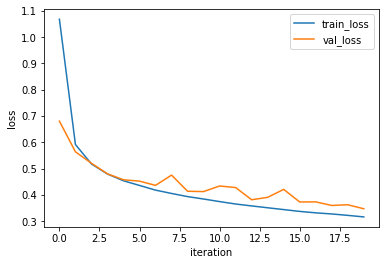

In [0]:
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [0]:
cn.score(x_val, y_val_encoded)

0.88175

## 08-5 케라스로 합성곱 신경망 모델을 만듭니다.

### 케라스로 합성곱 신경망 만들기

##### 1. 합성곱층 쌓기

Conv2D : 합성곱층 클래스 <br>
MaxPooling2D : 최대풀링 <br>
Flatten : 특성맵 일렬로 펼치기

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense #필요한 클래스들 임포트

1. 첫번째 매개변수는 합성곱 커널의 개수이다.<br>
2. 두번째 매개변수는 합성곱 커널의 크기로 높이와 너비를 튜플로 전달한다. 보통 3 X 3, 5 X 5 크기를 많이 사용한다.<br>
3. activation 매개변수에는 렐루, 패딩은 세임(케라스는 대소문자 구분x)
4. Sequential 클래스에 층을 처음 추가할 때는 배치 차원을 제외한 입력의 크기를 지정해야한다.

In [0]:
#합성곱층 쌓기
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
# 풀링층 쌓기, 기본값은 valid
conv1.add(MaxPooling2D((2, 2)))
#완전 연결층에 주입할 수 있도록 특성 맵 펼치기
conv1.add(Flatten())
#완전 연결층 쌓기
conv1.add(Dense(100, activation='relu')) #첫번째 완전 연결층
conv1.add(Dense(10, activation='softmax')) #두번째 완전 연결층

##### 모델구조 살펴보기

In [0]:
conv1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


배치차원이 none인 이유는 배치 입력의 개수는 훈련할 때 전달되는 샘플 개수에 따라 달라지기 때문이다. 합성곱 커널은 10개를 사용했으므로 마지막 차원이 10이다. 모델 파라미터의 개수는 전체 가중치의 크기와 커널마다 하나씩 절편을 추가하면 3 X 3 X 1 X 10 + 10 = 100개 이다. 첫 번째 완전 연결층 가중치 개수는 196,100개, 두 번째 1,010개이다. 때문에 합성곱층을 여러 개 추가해도 학습 할 모델 파라미터의 개수가 크게 들지 않기 때문에 계산 효율성이 좋다.

### 합성곱 신경망 모델 훈련하기

##### 1. 훈련준비

다중 분류를 위한 크로스 엔트로피 손실 함수를 사용한다. 정확도를 위해 metrics 매개변수에 accuracy를 리스트로 전달한다.

In [0]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

##### 2. Adam 옵티마이저 사용하기

옵티마이저
- 확률적 경사 하강법(SGD)
- 모멘텀(Momentum) : 운동량이라는 말과 같이 공이 바닥을 구르는 듯한 구현
- AdaGrad : 학습을 하면서 학습률을 점차 줄여가는 방법, 즉 '각각의' 매개변수에 '맞춤형' 값을 만든다. (과거의 기울기를 제곱하여 더해가는 방법)
- Adam : 모멘텀과 AdaGrad를 융합한 듯한 방법. 하이퍼파라미터의 '편향 보정'이 진행된다.

각 옵티마이저들 마다 상황을 고려해 여러가지로 시도해 보는게 좋다.

In [0]:
history = conv1.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 24s 507us/sample - loss: 0.4515 - accuracy: 0.8413 - val_loss: 0.3362 - val_accuracy: 0.8826
Epoch 2/20
48000/48000 [==============================] - 29s 605us/sample - loss: 0.3111 - accuracy: 0.8894 - val_loss: 0.2896 - val_accuracy: 0.8967
Epoch 3/20
48000/48000 [==============================] - 31s 650us/sample - loss: 0.2652 - accuracy: 0.9030 - val_loss: 0.2666 - val_accuracy: 0.9062
Epoch 4/20
48000/48000 [==============================] - 31s 637us/sample - loss: 0.2347 - accuracy: 0.9138 - val_loss: 0.2631 - val_accuracy: 0.9045
Epoch 5/20
48000/48000 [==============================] - 31s 640us/sample - loss: 0.2079 - accuracy: 0.9221 - val_loss: 0.2538 - val_accuracy: 0.9108
Epoch 6/20
48000/48000 [==============================] - 30s 633us/sample - loss: 0.1852 - accuracy: 0.9312 - val_loss: 0.2552 - val_accuracy: 0.9088
Epoch 7/20
48000/48000 [====================

##### 3. 손실 그래프와 정확도 그래프 확인

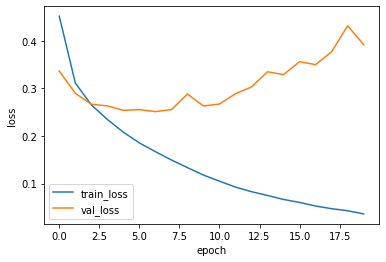

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

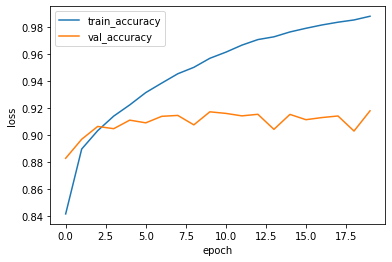

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [0]:
loss, accuracy = conv1.evaluate(x_val, y_val_encoded, verbose=0)

In [0]:
print(accuracy)

0.91775


92%로 증가 했지만 정확도와 손실을 보면 크게 증가했다. 이는 과대적합이 일찍 발생했음을 의미한다.

### 드롭아웃

<img src="https://github.com/dockhs1313/19-lab/blob/master/08%EB%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C/3.jpg?raw=true?raw=true" width="80%">

기량이 뛰어난 선수를 제외하여 기존 기량이 뛰어난 선수에게만 의존했던 전랴을 다른 선수에게도 고르게 훈련시키면서 전력 손실을 최소화 시킨다. 이와같이 특정 뉴런에 과도ㅇ하게 의존하지 않고 모든 뉴런이 의미있는 패턴을 학습해야 한다.

<img src="https://image.slidesharecdn.com/4-170508110332/95/4convolutional-neural-networks-34-638.jpg?cb=1494241445" width="80%">

<img src="https://t1.daumcdn.net/cfile/tistory/991613385BBCA0620A" width="80%">

### 드롭아웃 적용해 합성곱 신경망 구현

##### 1. 케라스로 만든 합성곱 신경망에 드롭아웃 적용하기

In [0]:
from tensorflow.keras.layers import Dropout

In [0]:
conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5)) #드롭아웃층 추가하기 // 훈련되는 가중치가 없고 텐서의 차원을 바꾸지 않는다.
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

In [0]:
conv2.summary() #드롭아웃 층

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

##### 2. 훈련하기

In [0]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
history = conv2.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 44s 907us/sample - loss: 0.5254 - accuracy: 0.8107 - val_loss: 0.3624 - val_accuracy: 0.8712
Epoch 2/20
48000/48000 [==============================] - 44s 907us/sample - loss: 0.3838 - accuracy: 0.8601 - val_loss: 0.3104 - val_accuracy: 0.8911
Epoch 3/20
48000/48000 [==============================] - 37s 777us/sample - loss: 0.3430 - accuracy: 0.8740 - val_loss: 0.2925 - val_accuracy: 0.8909
Epoch 4/20
48000/48000 [==============================] - 42s 868us/sample - loss: 0.3122 - accuracy: 0.8855 - val_loss: 0.2764 - val_accuracy: 0.9016
Epoch 5/20
48000/48000 [==============================] - 38s 791us/sample - loss: 0.2927 - accuracy: 0.8902 - val_loss: 0.2639 - val_accuracy: 0.9057
Epoch 6/20
48000/48000 [==============================] - 38s 781us/sample - loss: 0.2752 - accuracy: 0.8968 - val_loss: 0.2572 - val_accuracy: 0.9071
Epoch 7/20
48000/48000 [====================

##### 3. 손실 그래프와 정확도 그래프

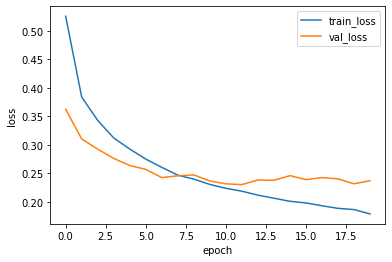

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

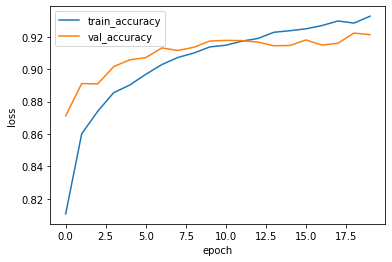

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [0]:
loss, accuracy = conv2.evaluate(x_val, y_val_encoded, verbose=0)

In [0]:
print(accuracy)

0.92125


### CNN 주요 모델들

### AlexNet

Recurrent Neural Network와 더불어 딥러닝 모델의 양대 산맥으로 주목받고 있는 CNN은 기본적으로 얀 르쿤이 1989년 제안한 구조를 토대로 하고 있습니다. 컴퓨터 비전 분야의 ‘올림픽’이라 할 수 있는 ILSVRC(ImageNet Large-Scale Visual Recognition Challenge)의 2012년 대회에서 제프리 힌튼 교수팀의 AlexNet이 top 5 test error 기준 15.4%를 기록해 2위(26.2%)를 큰 폭으로 따돌리고 1위를 차지했습니다.

여기서 top 5 test error란 모델이 예측한 최상위 5개 범주 가운데 정답이 없는 경우의 오류율을 나타냅니다. 당시 ILSVRC 데이터셋(Image은 1000개 범주 예측 문제였습니다. 어쨌든 AlexNet 덕분에 딥러닝, 특히 CNN이 세간의 주목을 받게 됐습니다. AlexNet 아키텍처의 주요 특징은 다음과 같습니다.

<img src="https://i.imgur.com/CwIvlUW.png?raw=true" width="100%">

- conv layer, max-pooling layer, dropout layer 5개
- fully connected layer 3개
- nonlinearity function : ReLU
- batch stochastic gradient descent <br>

AlexNet이 중요한 이유는 의미있는 성능을 낸 첫번째 CNN 아키텍처이자, AlexNet에 쓰인 드롭아웃 등 기법은 이 분야 표준으로 자리잡을 정도로 선도적인 역할을 했기 때문입니다.

### GoogleNet

AlexNet 이후 층을 더 깊게 쌓아 성능을 높이려는 시도들이 계속되었습니다. VGGNet(2014), GoogleNet(2015) 등이 바로 그것입니다. GoogleNet은 VGGNet보다 구조가 복잡해 널리 쓰이진 않았지만 아키텍처 면에서 주목을 받았습니다. 보통 하나의 conv layer에는 한 가지의 conv filter가 사용됩니다.

GoogleNet 연구진들은 한 가지의 conv filter를 적용한 conv layer를 단순히 깊게 쌓는 방법도 있지만, 하나의 layer에서도 다양한 종류의 filter나 pooling을 도입함으로써 개별 layer를 두텁게 확장시킬 수 있다는 창조적인 아이디어로 후배 연구자들에게 많은 영감을 주었습니다. 이들이 제안한 구조가 바로 Inception module입니다.

<img src="https://i.imgur.com/VY3BkBR.png?raw=true" width="100%">

Inception module에서 특히 주목받은 것이 바로 1×1 conv filter입니다. 가령 현재 층 입력데이터 이미지의 차원수가 100×100×60이고, 1×1 conv filter를 20개 사용한다면 데이터의 차원 수는 100×100×20으로 줄어듭니다. 60개 채널(차원)에 달하는 하나의 픽셀이 20차원의 feature space로 선형변환, 차원축소된 것이라고도 볼 수 있겠습니다.

### ResNet

ResNet(2015)은 2015년 ILSVRC에서 오류율 3.6%로 1등을 차지했습니다. 인간의 분류 오차가 5~10% 정도라는 걸 감안하면 놀라운 성적표입니다.

사실 AlexNet이 처음 제안된 이후로 CNN 아키텍처의 층은 점점 더 깊어졌습니다. AlexNet이 불과 5개 층에 불과한 반면 VGGNet은 19개 층, GoogleNet은 22개 층에 달합니다. 하지만 층이 깊어질 수록 역전파되는 그래디언트가 중간에 죽어서 학습이 잘 되지 않는 문제(gradient vanishing)가 발생했습니다. ResNet 저자들이 제시한 아래 학습그래프를 보면 이같은 문제가 뚜렷이 나타납니다.

<img src="https://i.imgur.com/zJm2b5g.png" width="100%">

ResNet 저자들의 핵심 아이디어는 다음 그림과 같은 residual block입니다. 그래디언트가 잘 흐를 수 있도록 일종의 지름길(shortcut, skip connection)을 만들어 주자는 생각입니다. 이는 forget gate 등을 도입해 이전 스텝의 그래디언트(정보)를 좀 더 잘 흐르게 만드려는 Long Term Short Memory(LSTM)의 철학과 본질적으로 유사합니다.

<img src="https://i.imgur.com/fse3Ntq.png" width="100%">

ResNet의 성능이 좋은 이유는 그래디언트 문제 말고 또 있습니다. Veit et al. (2016)은 residual block이 앙상블(ensemble) 모델을 구축한 것과 비슷한 효과를 낸다고 주장했습니다. residual block의 skip connection 덕분에 입력데이터와 그래디언트가 오갈 수 있는 통로가 크게 늘어나기 때문입니다. (n개 skip connection이 있다면 $ 2^n $개의 서로 다른 통로 존재) 이를 직관적으로 나타낸 그림은 아래 그림과 같습니다.

<img src="https://i.imgur.com/CjLtXb0.png" width="100%">

### DenseNet

DenseNet(2016)은 ResNet에서 한발 더 나아가 전체 네트워크의 모든 층과 통하는 지름길을 만들었습니다. conv-ReLU-conv 사이만 뛰어넘는 지름길을 만들었던 ResNet보다 훨씬 과감한 시도입니다. DenseNet의 전체적인 아키텍처는 다음과 같습니다.

<img src="https://i.imgur.com/EITg2BX.png" width="100%">

### Region Based CNNs

R-CNN(2013), Fast R-CNN(2015), Faster R-CNN(2015) 등은 object detection 문제를 풀기 위해 제안된 모델들입니다. object detection이란 이미지가 주어졌을 때 해당 이미지 속에 들어있는 오브젝트의 경계(bounding box)를 찾아내는 작업입니다. object detection 문제는 크게 오브젝트의 경계를 찾아내는 작업(region proposal step), 해당 오브젝트가 무엇인지 맞추는 작업(classification step) 둘로 나뉩니다. CNN은 여기에서 이미지의 특성을 추출하는 데 중요한 역할을 합니다. 모델이 거듭될 수록 정확도는 물론 속도도 크게 향상되는 추세입니다.

### CNNs for NLP

문서분류에서 높은 성능으로 주목받은 CNN 아키텍처는 Kim(2014)입니다. 단어벡터들을 붙여서 행렬 형태의 입력값을 만들고, 너비가 단어벡터의 차원수와 일치하는 필터를 씁니다. conv layer가 단 1개뿐이지만 필터를 100개 이상 써서 두텁게 만든 것도 특징입니다. 다음 그림과 같습니다.

<img src="https://i.imgur.com/JN72JHW.png" width="100%">

위 그림에서도 알 수 있듯 Kim(2014)의 단점은 conv filter가 돌 때 이웃단어들을 고려할 수는 있지만, 멀리 떨어져 있는 단어들을 감안하기가 어렵다는 점입니다. 이에 Kalchbrenner et al.(2014)는 dynamic k-max pooling 기법을 제안했는데요. 풀링을 할 때 내림차순으로 k개를 선택하되 순서를 보존하는 방식입니다. 아래 그림에서 첫번째 conv layer에선 5개, 두번째 conv layer에선 3개를 풀링한 것입니다. 결과적으로 Recursive Neural Network와 유사한 파싱트리 모양의 구조가 됩니다.

<img src="https://i.imgur.com/WDVOZIH.png" width="100%">

한편 위의 연구들은 단어 수준에서 문서분류를 수행했는데, 최근엔 글자 수준의 CNN 아키텍처도 제안되고 있습니다. 단어(글자)벡터와 문서의 외부정보를 합쳐서 분류 성능을 높이려는 시도도 제안되고 있습니다.

